In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Udem/vision/

/content/drive/MyDrive/Udem/vision


In [2]:
#!unzip patches.zip
#!rm -rf patches
# !rm -rf patches.tgz
#!tar -zxvf patches9_9_2000.tgz
!tar -zxvf resized.tgz

resized/
resized/clean_right/
resized/clean_left/
resized/disparities/
resized/disparities/ambush_7/
resized/disparities/sleeping_1/
resized/disparities/ambush_6/
resized/disparities/alley_1/
resized/disparities/cave_2/
resized/disparities/cave_4/
resized/disparities/market_2/
resized/disparities/market_5/
resized/disparities/bamboo_2/
resized/disparities/mountain_1/
resized/disparities/shaman_2/
resized/disparities/bandage_1/
resized/disparities/shaman_3/
resized/disparities/sleeping_2/
resized/disparities/ambush_4/
resized/disparities/ambush_2/
resized/disparities/ambush_5/
resized/disparities/temple_3/
resized/disparities/alley_2/
resized/disparities/temple_2/
resized/disparities/market_6/
resized/disparities/bamboo_1/
resized/disparities/bandage_2/
resized/disparities/bandage_2/frame_0010.png
resized/disparities/bandage_2/frame_0040.png
resized/disparities/bandage_2/frame_0050.png
resized/disparities/bandage_2/frame_0020.png
resized/disparities/bandage_2/frame_0030.png
resized/disp

In [ ]:
len(os.listdir('/content/patches/train'))

60000

(9, 9)


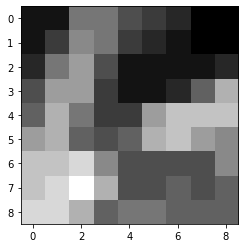

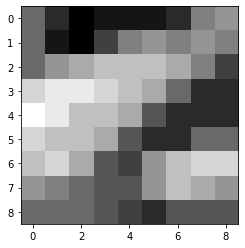

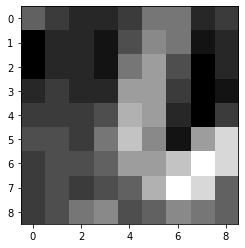

In [ ]:
import cv2
import matplotlib.pyplot as plt

id=8
img = cv2.imread(f'/content/patches/train/{id}_left.png',cv2.IMREAD_GRAYSCALE)
print(img.shape)
plt.imshow(img,cmap=plt.get_cmap('gray'))
plt.show()
img = cv2.imread(f'/content/patches/train/{id}_right_pos.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap=plt.get_cmap('gray'))
plt.show()
img = cv2.imread(f'/content/patches/train/{id}_right_neg.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap=plt.get_cmap('gray'))
plt.show()


In [ ]:
len(os.listdir(os.path.join('/content', 'patches','train')))

90000

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def fun(module,grad_in,grad_out):
    print('grad_in')
    #print(grad_in)     # add break point here
    print('grad_out')
    print(grad_out)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 112, 3).cuda()
        self.conv2 = nn.Conv2d(112, 112, 3).cuda()
        self.conv3 = nn.Conv2d(112, 112, 3).cuda()

        self.dropout = nn.Dropout(0.3)
        self.bn1d_1 = nn.BatchNorm1d(383)
        self.bn1d_2 = nn.BatchNorm1d(383)
        self.fc1 = nn.Linear(2*112 * 3 * 3, 383).cuda()
        self.fc2 = nn.Linear(383, 383).cuda()
        self.fc3 = nn.Linear(383, 1).cuda()

    def forward(self, left, right):

      batch_size = left.size()[0]
      
      left = self.conv1(left)
      left = self.conv2(left)
      left = self.conv3(left)

      left = left.view(batch_size, 112 * 3 * 3)

      right = F.relu(self.conv1(right))
      right = F.relu(self.conv2(right))
      right = F.relu(self.conv3(right))
      
      right = right.view(batch_size, 112 * 3 * 3)
      
      concat = torch.cat((left, right), dim=1)
      fc = self.bn1d_1(F.relu(self.fc1(concat)))
      fc = self.bn1d_2(F.relu(self.fc2(fc)))
      fc = torch.sigmoid(self.fc3(fc))
      
      return torch.squeeze(fc)
    
    def listener_grad(self):
      def hook(grad):
        print(grad)

      return hook

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)


In [ ]:
import torch
import math
import os
import numpy as np
import cv2

class SintelDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, dir, transform=None, type='train', train_size_rate=1):
    'Initialization'
    self.dir = dir
    self.transform = transform
    all_images=math.ceil(len(os.listdir(self.dir))/3)
    
    if type in 'train':
      start_index=0
      end_index=math.floor(all_images*train_size_rate)
    
    if type in 'test':
      start_index=math.ceil(all_images*(1-train_size_rate))
      end_index=all_images

    x = []
    y = []
    for i in range(start_index, end_index):
      left_image = cv2.imread(os.path.join(self.dir, f'{i}_left.png'), cv2.IMREAD_GRAYSCALE)
      #left_image =  left_image/255
      right_pos_image = cv2.imread(os.path.join(self.dir, f'{i}_right_pos.png'), cv2.IMREAD_GRAYSCALE)
      #right_pos_image =  right_pos_image/255
      right_neg_image = cv2.imread(os.path.join(self.dir, f'{i}_right_neg.png'), cv2.IMREAD_GRAYSCALE)
      #right_neg_image =  right_neg_image/255
      x.append({'left': left_image.astype(np.float32), 'right': right_pos_image.astype(np.float32)})
      y.append(1)
      x.append({'left': left_image.astype(np.float32), 'right': right_neg_image.astype(np.float32)})
      y.append(0)

    self.x = np.array(x)
    self.y = np.array(y, dtype=np.float32)
        
  def get_x():
    return self.x

  def get_y():
    return self.y

  def __len__(self):
    'Denotes the total number of samples'
    return len(self.y)

  def __getitem__(self, index):
    'Generates one sample of data'
    # Select sample
    # left_image = cv2.imread(os.path.join(self.dir, self.x[index,0]), cv2.IMREAD_GRAYSCALE)
    # left_image = (left_image-left_image.mean())/left_image.std()
    # right_image = cv2.imread(os.path.join(self.dir, self.x[index,1]), cv2.IMREAD_GRAYSCALE)
    # right_image = (right_image-right_image.mean())/right_image.std()
    left_image = self.x[index]['left']
    right_image = self.x[index]['right']
    y = self.y[index]

    # if y == 0:
    #   right_image = right_image * 0 + np.random.rand(right_image.shape[0], right_image.shape[1])
    # if y == 1:
    #   right_image = left_image
    #left_image=left_image.astype(np.float32)
    #right_image=right_image.astype(np.float32)
    if self.transform:
      left_image = self.transform(left_image)
      right_image = self.transform(right_image)
    return [left_image, right_image], y

In [ ]:

ds = SintelDataset(os.path.join('/content','patches', 'train'), type='train', train_size_rate=0.8)
print(len(ds))
x, y = ds[0]


ds = SintelDataset(os.path.join('/content','patches', 'train'), type='test', train_size_rate=0.2)
print(len(ds))
x, y = ds[0]

32000
8000


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = SintelDataset(os.path.join('/content','patches', 'train'), transform, type='train', train_size_rate=0.8)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=8)

testset = SintelDataset(os.path.join('/content','patches', 'train'), transform, type='test', train_size_rate=0.2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=True, num_workers=8)

print(len(trainloader))
print(len(testloader))

1250
313


In [ ]:
import time
from sklearn.metrics import accuracy_score
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)

criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
#optimizer = optim.SGD(net.parameters(),lr=0.0001, momentum=0.9)
optimizer = optim.RMSprop(net.parameters(),lr=0.000001)

#optimizer = optim.SGD(net.parameters(),lr=0.0003, momentum=0.6)
#optimizer = optim.Adam(net.parameters(),lr=0.00001)


def compute_loss(dataLoader, loss, acc):
  correct = 0
  total = 0
  loss_val = 0
  with torch.no_grad():
    for data in dataLoader:
      left, right, labels = data[0][0].to(device),data[0][1].to(device), data[1].to(device)
      outputs = net(left, right)
      #print(data[0:50])
      predicted = torch.round(outputs.data)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      loss_val += criterion(outputs, labels).item()
    loss.append(loss_val / len(dataLoader))
    acc.append(100 * correct / total)
  

loss_epoch = {'traning':[], 'validation':[]}
acc_epoch = {'traning':[], 'validation':[]}
y_true = []
y_pred = []
for epoch in range(50):  # loop over the dataset multiple times
    #print('start',net.fc1.weight.data[0,0:100])
    running_loss = 0.0
    total = 0
    total_loss = 0
    for i, data in enumerate(trainloader, 10):
        # get the inputs; data is a list of [inputs, labels]
        left, right, labels = data[0][0].to(device),data[0][1].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(left, right)
        loss = criterion(outputs, labels)
        loss.backward()
        #plot_grad_flow(net.named_parameters())
        optimizer.step()

        
    # print("Accuracy on training set is" ,         
    # accuracy_score(y_true,y_pred))
        
        
    print('epoch', epoch)
    compute_loss(testloader, loss_epoch['validation'], acc_epoch['validation'])
    compute_loss(trainloader, loss_epoch['traning'], acc_epoch['traning'])
    print('loss-val', loss_epoch['validation'])
    # print('acc-val', acc_epoch['validation'])
    print('loss', loss_epoch['traning'])
    # print('acc', acc_epoch['traning'])
    # print(net.left_conv1.weight.data[0,0,0])
    # time.sleep(2)

print('Finished Training')


epoch 0
loss-val [0.7045862667095928]
loss [0.7039621649742126]
epoch 1
loss-val [0.7045862667095928, 0.6911258124314938]
loss [0.7039621649742126, 0.6910545555591583]
epoch 2
loss-val [0.7045862667095928, 0.6911258124314938, 0.679872320482906]
loss [0.7039621649742126, 0.6910545555591583, 0.679729533290863]
epoch 3
loss-val [0.7045862667095928, 0.6911258124314938, 0.679872320482906, 0.6681515635392917]
loss [0.7039621649742126, 0.6910545555591583, 0.679729533290863, 0.6681362924575805]
epoch 4
loss-val [0.7045862667095928, 0.6911258124314938, 0.679872320482906, 0.6681515635392917, 0.6586967761905048]
loss [0.7039621649742126, 0.6910545555591583, 0.679729533290863, 0.6681362924575805, 0.6587013278484345]
epoch 5
loss-val [0.7045862667095928, 0.6911258124314938, 0.679872320482906, 0.6681515635392917, 0.6586967761905048, 0.650515768284234]
loss [0.7039621649742126, 0.6910545555591583, 0.679729533290863, 0.6681362924575805, 0.6587013278484345, 0.6506080703735352]
epoch 6
loss-val [0.70458

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
AssertionError: can only join a child process
    sel

loss-val [0.7045862667095928, 0.6911258124314938, 0.679872320482906, 0.6681515635392917, 0.6586967761905048, 0.650515768284234, 0.6421516465302854, 0.6366937878413703, 0.6293302018421526, 0.6240397706961098, 0.6206686982331565, 0.6161482711188709, 0.6118411823583487, 0.6087254508615683, 0.6089601897583983, 0.6041851811134777, 0.6022004945971333, 0.6008666283406389, 0.5974444861229236, 0.5963220689624262, 0.5948172005982445, 0.5928921549084087, 0.5933834076308595]
loss [0.7039621649742126, 0.6910545555591583, 0.679729533290863, 0.6681362924575805, 0.6587013278484345, 0.6506080703735352, 0.6420987230300903, 0.6369716019630433, 0.6295709697723388, 0.6244762362003327, 0.6209060765743256, 0.6164897087097168, 0.612275763463974, 0.6088516141414643, 0.6087633177280426, 0.6043447622299194, 0.6024570606708527, 0.6008832034111022, 0.5975307021617889, 0.5967323167324066, 0.5949482807159424, 0.5925443081855774, 0.5929631542205811]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter 

epoch 23


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
    self._shutdown_workers()
Tracebac

loss-val [0.7045862667095928, 0.6911258124314938, 0.679872320482906, 0.6681515635392917, 0.6586967761905048, 0.650515768284234, 0.6421516465302854, 0.6366937878413703, 0.6293302018421526, 0.6240397706961098, 0.6206686982331565, 0.6161482711188709, 0.6118411823583487, 0.6087254508615683, 0.6089601897583983, 0.6041851811134777, 0.6022004945971333, 0.6008666283406389, 0.5974444861229236, 0.5963220689624262, 0.5948172005982445, 0.5928921549084087, 0.5933834076308595, 0.5900947763896979]
loss [0.7039621649742126, 0.6910545555591583, 0.679729533290863, 0.6681362924575805, 0.6587013278484345, 0.6506080703735352, 0.6420987230300903, 0.6369716019630433, 0.6295709697723388, 0.6244762362003327, 0.6209060765743256, 0.6164897087097168, 0.612275763463974, 0.6088516141414643, 0.6087633177280426, 0.6043447622299194, 0.6024570606708527, 0.6008832034111022, 0.5975307021617889, 0.5967323167324066, 0.5949482807159424, 0.5925443081855774, 0.5929631542205811, 0.589530961227417]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/datalo

epoch 24


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object

loss-val [0.7045862667095928, 0.6911258124314938, 0.679872320482906, 0.6681515635392917, 0.6586967761905048, 0.650515768284234, 0.6421516465302854, 0.6366937878413703, 0.6293302018421526, 0.6240397706961098, 0.6206686982331565, 0.6161482711188709, 0.6118411823583487, 0.6087254508615683, 0.6089601897583983, 0.6041851811134777, 0.6022004945971333, 0.6008666283406389, 0.5974444861229236, 0.5963220689624262, 0.5948172005982445, 0.5928921549084087, 0.5933834076308595, 0.5900947763896979, 0.5913708729865833]
loss [0.7039621649742126, 0.6910545555591583, 0.679729533290863, 0.6681362924575805, 0.6587013278484345, 0.6506080703735352, 0.6420987230300903, 0.6369716019630433, 0.6295709697723388, 0.6244762362003327, 0.6209060765743256, 0.6164897087097168, 0.612275763463974, 0.6088516141414643, 0.6087633177280426, 0.6043447622299194, 0.6024570606708527, 0.6008832034111022, 0.5975307021617889, 0.5967323167324066, 0.5949482807159424, 0.5925443081855774, 0.5929631542205811, 0.589530961227417, 0.5912700

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    assert self._parent_pid == os.getpid(), 'can only join a child process'
    self._shutdown_workers()
AssertionError: can only

epoch 25


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDat

loss-val [0.7045862667095928, 0.6911258124314938, 0.679872320482906, 0.6681515635392917, 0.6586967761905048, 0.650515768284234, 0.6421516465302854, 0.6366937878413703, 0.6293302018421526, 0.6240397706961098, 0.6206686982331565, 0.6161482711188709, 0.6118411823583487, 0.6087254508615683, 0.6089601897583983, 0.6041851811134777, 0.6022004945971333, 0.6008666283406389, 0.5974444861229236, 0.5963220689624262, 0.5948172005982445, 0.5928921549084087, 0.5933834076308595, 0.5900947763896979, 0.5913708729865833, 0.5873363296063944]
loss [0.7039621649742126, 0.6910545555591583, 0.679729533290863, 0.6681362924575805, 0.6587013278484345, 0.6506080703735352, 0.6420987230300903, 0.6369716019630433, 0.6295709697723388, 0.6244762362003327, 0.6209060765743256, 0.6164897087097168, 0.612275763463974, 0.6088516141414643, 0.6087633177280426, 0.6043447622299194, 0.6024570606708527, 0.6008832034111022, 0.5975307021617889, 0.5967323167324066, 0.5949482807159424, 0.5925443081855774, 0.5929631542205811, 0.589530

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
    self._shutdown_workers()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/usr/local/lib/p

epoch 26


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

loss-val [0.7045862667095928, 0.6911258124314938, 0.679872320482906, 0.6681515635392917, 0.6586967761905048, 0.650515768284234, 0.6421516465302854, 0.6366937878413703, 0.6293302018421526, 0.6240397706961098, 0.6206686982331565, 0.6161482711188709, 0.6118411823583487, 0.6087254508615683, 0.6089601897583983, 0.6041851811134777, 0.6022004945971333, 0.6008666283406389, 0.5974444861229236, 0.5963220689624262, 0.5948172005982445, 0.5928921549084087, 0.5933834076308595, 0.5900947763896979, 0.5913708729865833, 0.5873363296063944, 0.588292403723866]
loss [0.7039621649742126, 0.6910545555591583, 0.679729533290863, 0.6681362924575805, 0.6587013278484345, 0.6506080703735352, 0.6420987230300903, 0.6369716019630433, 0.6295709697723388, 0.6244762362003327, 0.6209060765743256, 0.6164897087097168, 0.612275763463974, 0.6088516141414643, 0.6087633177280426, 0.6043447622299194, 0.6024570606708527, 0.6008832034111022, 0.5975307021617889, 0.5967323167324066, 0.5949482807159424, 0.5925443081855774, 0.5929631

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    self._shutdown_workers()
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/lib/python3.6/multiprocessing/process.py", line 1

epoch 27


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Exception ignored in: <bo

loss-val [0.7045862667095928, 0.6911258124314938, 0.679872320482906, 0.6681515635392917, 0.6586967761905048, 0.650515768284234, 0.6421516465302854, 0.6366937878413703, 0.6293302018421526, 0.6240397706961098, 0.6206686982331565, 0.6161482711188709, 0.6118411823583487, 0.6087254508615683, 0.6089601897583983, 0.6041851811134777, 0.6022004945971333, 0.6008666283406389, 0.5974444861229236, 0.5963220689624262, 0.5948172005982445, 0.5928921549084087, 0.5933834076308595, 0.5900947763896979, 0.5913708729865833, 0.5873363296063944, 0.588292403723866, 0.5852444550861566]
loss [0.7039621649742126, 0.6910545555591583, 0.679729533290863, 0.6681362924575805, 0.6587013278484345, 0.6506080703735352, 0.6420987230300903, 0.6369716019630433, 0.6295709697723388, 0.6244762362003327, 0.6209060765743256, 0.6164897087097168, 0.612275763463974, 0.6088516141414643, 0.6087633177280426, 0.6043447622299194, 0.6024570606708527, 0.6008832034111022, 0.5975307021617889, 0.5967323167324066, 0.5949482807159424, 0.5925443

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

epoch 28


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter 

loss-val [0.7045862667095928, 0.6911258124314938, 0.679872320482906, 0.6681515635392917, 0.6586967761905048, 0.650515768284234, 0.6421516465302854, 0.6366937878413703, 0.6293302018421526, 0.6240397706961098, 0.6206686982331565, 0.6161482711188709, 0.6118411823583487, 0.6087254508615683, 0.6089601897583983, 0.6041851811134777, 0.6022004945971333, 0.6008666283406389, 0.5974444861229236, 0.5963220689624262, 0.5948172005982445, 0.5928921549084087, 0.5933834076308595, 0.5900947763896979, 0.5913708729865833, 0.5873363296063944, 0.588292403723866, 0.5852444550861566, 0.5883927069152125]
loss [0.7039621649742126, 0.6910545555591583, 0.679729533290863, 0.6681362924575805, 0.6587013278484345, 0.6506080703735352, 0.6420987230300903, 0.6369716019630433, 0.6295709697723388, 0.6244762362003327, 0.6209060765743256, 0.6164897087097168, 0.612275763463974, 0.6088516141414643, 0.6087633177280426, 0.6043447622299194, 0.6024570606708527, 0.6008832034111022, 0.5975307021617889, 0.5967323167324066, 0.5949482

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Traceback (most recent call last):
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutd

epoch 29


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
AssertionError: can only join a child process
    sel

loss-val [0.7045862667095928, 0.6911258124314938, 0.679872320482906, 0.6681515635392917, 0.6586967761905048, 0.650515768284234, 0.6421516465302854, 0.6366937878413703, 0.6293302018421526, 0.6240397706961098, 0.6206686982331565, 0.6161482711188709, 0.6118411823583487, 0.6087254508615683, 0.6089601897583983, 0.6041851811134777, 0.6022004945971333, 0.6008666283406389, 0.5974444861229236, 0.5963220689624262, 0.5948172005982445, 0.5928921549084087, 0.5933834076308595, 0.5900947763896979, 0.5913708729865833, 0.5873363296063944, 0.588292403723866, 0.5852444550861566, 0.5883927069152125, 0.5842262129433239]
loss [0.7039621649742126, 0.6910545555591583, 0.679729533290863, 0.6681362924575805, 0.6587013278484345, 0.6506080703735352, 0.6420987230300903, 0.6369716019630433, 0.6295709697723388, 0.6244762362003327, 0.6209060765743256, 0.6164897087097168, 0.612275763463974, 0.6088516141414643, 0.6087633177280426, 0.6043447622299194, 0.6024570606708527, 0.6008832034111022, 0.5975307021617889, 0.5967323

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object

epoch 42
loss-val [0.7045862667095928, 0.6911258124314938, 0.679872320482906, 0.6681515635392917, 0.6586967761905048, 0.650515768284234, 0.6421516465302854, 0.6366937878413703, 0.6293302018421526, 0.6240397706961098, 0.6206686982331565, 0.6161482711188709, 0.6118411823583487, 0.6087254508615683, 0.6089601897583983, 0.6041851811134777, 0.6022004945971333, 0.6008666283406389, 0.5974444861229236, 0.5963220689624262, 0.5948172005982445, 0.5928921549084087, 0.5933834076308595, 0.5900947763896979, 0.5913708729865833, 0.5873363296063944, 0.588292403723866, 0.5852444550861566, 0.5883927069152125, 0.5842262129433239, 0.583276998311186, 0.5822591880639902, 0.5833664909719278, 0.5808187237562844, 0.580759906921143, 0.579222752453801, 0.5788796976351509, 0.5851324025434427, 0.5800224258876837, 0.5787784118241015, 0.5817167423784543, 0.5796803043673213, 0.5777673608959674]
loss [0.7039621649742126, 0.6910545555591583, 0.679729533290863, 0.6681362924575805, 0.6587013278484345, 0.6506080703735352, 0.

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/lib/python3.6/multiprocessing/process.py", line 1

epoch 44


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

loss-val [0.7045862667095928, 0.6911258124314938, 0.679872320482906, 0.6681515635392917, 0.6586967761905048, 0.650515768284234, 0.6421516465302854, 0.6366937878413703, 0.6293302018421526, 0.6240397706961098, 0.6206686982331565, 0.6161482711188709, 0.6118411823583487, 0.6087254508615683, 0.6089601897583983, 0.6041851811134777, 0.6022004945971333, 0.6008666283406389, 0.5974444861229236, 0.5963220689624262, 0.5948172005982445, 0.5928921549084087, 0.5933834076308595, 0.5900947763896979, 0.5913708729865833, 0.5873363296063944, 0.588292403723866, 0.5852444550861566, 0.5883927069152125, 0.5842262129433239, 0.583276998311186, 0.5822591880639902, 0.5833664909719278, 0.5808187237562844, 0.580759906921143, 0.579222752453801, 0.5788796976351509, 0.5851324025434427, 0.5800224258876837, 0.5787784118241015, 0.5817167423784543, 0.5796803043673213, 0.5777673608959674, 0.5784765224868116, 0.5769418169515201]
loss [0.7039621649742126, 0.6910545555591583, 0.679729533290863, 0.6681362924575805, 0.658701327

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter ob

epoch 45


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/

loss-val [0.7045862667095928, 0.6911258124314938, 0.679872320482906, 0.6681515635392917, 0.6586967761905048, 0.650515768284234, 0.6421516465302854, 0.6366937878413703, 0.6293302018421526, 0.6240397706961098, 0.6206686982331565, 0.6161482711188709, 0.6118411823583487, 0.6087254508615683, 0.6089601897583983, 0.6041851811134777, 0.6022004945971333, 0.6008666283406389, 0.5974444861229236, 0.5963220689624262, 0.5948172005982445, 0.5928921549084087, 0.5933834076308595, 0.5900947763896979, 0.5913708729865833, 0.5873363296063944, 0.588292403723866, 0.5852444550861566, 0.5883927069152125, 0.5842262129433239, 0.583276998311186, 0.5822591880639902, 0.5833664909719278, 0.5808187237562844, 0.580759906921143, 0.579222752453801, 0.5788796976351509, 0.5851324025434427, 0.5800224258876837, 0.5787784118241015, 0.5817167423784543, 0.5796803043673213, 0.5777673608959674, 0.5784765224868116, 0.5769418169515201, 0.5775141359898991]
loss [0.7039621649742126, 0.6910545555591583, 0.679729533290863, 0.668136292

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  

epoch 46


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
    self._shutdown_workers()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/d

loss-val [0.7045862667095928, 0.6911258124314938, 0.679872320482906, 0.6681515635392917, 0.6586967761905048, 0.650515768284234, 0.6421516465302854, 0.6366937878413703, 0.6293302018421526, 0.6240397706961098, 0.6206686982331565, 0.6161482711188709, 0.6118411823583487, 0.6087254508615683, 0.6089601897583983, 0.6041851811134777, 0.6022004945971333, 0.6008666283406389, 0.5974444861229236, 0.5963220689624262, 0.5948172005982445, 0.5928921549084087, 0.5933834076308595, 0.5900947763896979, 0.5913708729865833, 0.5873363296063944, 0.588292403723866, 0.5852444550861566, 0.5883927069152125, 0.5842262129433239, 0.583276998311186, 0.5822591880639902, 0.5833664909719278, 0.5808187237562844, 0.580759906921143, 0.579222752453801, 0.5788796976351509, 0.5851324025434427, 0.5800224258876837, 0.5787784118241015, 0.5817167423784543, 0.5796803043673213, 0.5777673608959674, 0.5784765224868116, 0.5769418169515201, 0.5775141359898991, 0.5752407472354536]
loss [0.7039621649742126, 0.6910545555591583, 0.67972953

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object

epoch 47


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
    self._shutdown_workers()
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_

loss-val [0.7045862667095928, 0.6911258124314938, 0.679872320482906, 0.6681515635392917, 0.6586967761905048, 0.650515768284234, 0.6421516465302854, 0.6366937878413703, 0.6293302018421526, 0.6240397706961098, 0.6206686982331565, 0.6161482711188709, 0.6118411823583487, 0.6087254508615683, 0.6089601897583983, 0.6041851811134777, 0.6022004945971333, 0.6008666283406389, 0.5974444861229236, 0.5963220689624262, 0.5948172005982445, 0.5928921549084087, 0.5933834076308595, 0.5900947763896979, 0.5913708729865833, 0.5873363296063944, 0.588292403723866, 0.5852444550861566, 0.5883927069152125, 0.5842262129433239, 0.583276998311186, 0.5822591880639902, 0.5833664909719278, 0.5808187237562844, 0.580759906921143, 0.579222752453801, 0.5788796976351509, 0.5851324025434427, 0.5800224258876837, 0.5787784118241015, 0.5817167423784543, 0.5796803043673213, 0.5777673608959674, 0.5784765224868116, 0.5769418169515201, 0.5775141359898991, 0.5752407472354536, 0.5758033044422015]
loss [0.7039621649742126, 0.69105455

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object

epoch 48


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/p

loss-val [0.7045862667095928, 0.6911258124314938, 0.679872320482906, 0.6681515635392917, 0.6586967761905048, 0.650515768284234, 0.6421516465302854, 0.6366937878413703, 0.6293302018421526, 0.6240397706961098, 0.6206686982331565, 0.6161482711188709, 0.6118411823583487, 0.6087254508615683, 0.6089601897583983, 0.6041851811134777, 0.6022004945971333, 0.6008666283406389, 0.5974444861229236, 0.5963220689624262, 0.5948172005982445, 0.5928921549084087, 0.5933834076308595, 0.5900947763896979, 0.5913708729865833, 0.5873363296063944, 0.588292403723866, 0.5852444550861566, 0.5883927069152125, 0.5842262129433239, 0.583276998311186, 0.5822591880639902, 0.5833664909719278, 0.5808187237562844, 0.580759906921143, 0.579222752453801, 0.5788796976351509, 0.5851324025434427, 0.5800224258876837, 0.5787784118241015, 0.5817167423784543, 0.5796803043673213, 0.5777673608959674, 0.5784765224868116, 0.5769418169515201, 0.5775141359898991, 0.5752407472354536, 0.5758033044422015, 0.5753629234271308]
loss [0.70396216

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only

epoch 49


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d652cbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

loss-val [0.7045862667095928, 0.6911258124314938, 0.679872320482906, 0.6681515635392917, 0.6586967761905048, 0.650515768284234, 0.6421516465302854, 0.6366937878413703, 0.6293302018421526, 0.6240397706961098, 0.6206686982331565, 0.6161482711188709, 0.6118411823583487, 0.6087254508615683, 0.6089601897583983, 0.6041851811134777, 0.6022004945971333, 0.6008666283406389, 0.5974444861229236, 0.5963220689624262, 0.5948172005982445, 0.5928921549084087, 0.5933834076308595, 0.5900947763896979, 0.5913708729865833, 0.5873363296063944, 0.588292403723866, 0.5852444550861566, 0.5883927069152125, 0.5842262129433239, 0.583276998311186, 0.5822591880639902, 0.5833664909719278, 0.5808187237562844, 0.580759906921143, 0.579222752453801, 0.5788796976351509, 0.5851324025434427, 0.5800224258876837, 0.5787784118241015, 0.5817167423784543, 0.5796803043673213, 0.5777673608959674, 0.5784765224868116, 0.5769418169515201, 0.5775141359898991, 0.5752407472354536, 0.5758033044422015, 0.5753629234271308, 0.57640924507055

In [ ]:
torch.save(net.state_dict(), './model.torch')

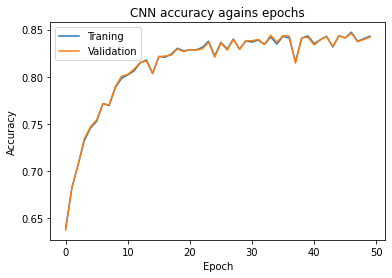

84.2

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(range(50)), [i/100 for i in acc_epoch['traning']], '-',label='Traning')
plt.plot(list(range(50)), [i/100 for i in acc_epoch['validation']], '-',label='Validation')
plt.legend()
plt.title(f"CNN accuracy agains epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()
acc_epoch['validation'][-1]

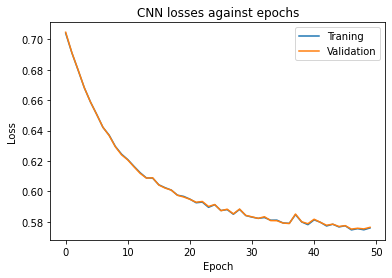

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(range(50)), loss_epoch['traning'], '-',label='Traning')
plt.plot(list(range(50)), loss_epoch['validation'], '-',label='Validation')
plt.legend()
plt.title(f"CNN losses against epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [1]:
import torch
import math
import os
import numpy as np
import cv2
import torch.nn as nn
import torch.nn.functional as F

class Net_Matching_Cost():
    def __init__(self):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.conv1 = nn.Conv2d(1, 112, 3, padding=1).to(device)
        self.conv2 = nn.Conv2d(112, 112, 3, padding=1).to(device)
        self.conv3 = nn.Conv2d(112, 112, 3, padding=1).cuda()

        self.disp_conv1 = nn.Conv2d(224, 383, 3, padding=1).to(device)
        self.disp_conv2 = nn.Conv2d(383, 383, 1).to(device)
        self.disp_conv3 = nn.Conv2d(383, 1, 1).to(device)

    def predict(self, left, right, max_disp):
      
      img_rows = right.shape[2]
      img_cols = right.shape[3]

      #batch_size = left.size()[0]
      
      left = self.conv1(left)
      left = self.conv2(left)
      left = self.conv3(left)

      right = F.relu(self.conv1(right))
      right = F.relu(self.conv2(right))
      right = F.relu(self.conv3(right))
     
      disp_maps = np.zeros((img_rows, img_cols, max_disp), dtype=np.float)
      for d in range(1, max_disp+1):
        left_fc = left[:, :, :, d:]
        right_fc = right[:, :, :, 0:-d]
        # print('left',left_fc.shape)
        # print('right',right_fc.shape)
        concat = torch.cat((left_fc, right_fc), axis=1)
        #print('concat', concat.shape)
        fc = F.relu(self.disp_conv1(concat))
        fc = F.relu(self.disp_conv2(fc))
        fc = torch.sigmoid(self.disp_conv3(fc))
        disp_maps[:, d:, d-1] = torch.squeeze(fc).cpu().numpy()
      
      return disp_maps

net_mc = Net_Matching_Cost()



In [3]:
t=torch.zeros((5, 5)) 
t[1,0:2]=torch.ones((1, 2)) 
print(t)

tensor([[0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


In [4]:
saved_model = torch.load('./model.torch')

In [5]:
print(net_mc.conv1.weight.shape)
net_mc.conv1.weight = nn.Parameter(saved_model['conv1.weight'])
net_mc.conv1.bias = nn.Parameter(saved_model['conv1.bias'])
print(net_mc.conv1.weight.shape)
print(net_mc.conv2.weight.shape)
net_mc.conv2.weight = nn.Parameter(saved_model['conv2.weight'])
net_mc.conv2.bias = nn.Parameter(saved_model['conv2.bias'])
print(net_mc.conv2.weight.shape)
print(net_mc.conv3.weight.shape)
net_mc.conv3.weight = nn.Parameter(saved_model['conv3.weight'])
net_mc.conv3.bias = nn.Parameter(saved_model['conv3.bias'])
print(net_mc.conv3.weight.shape)

torch.Size([112, 1, 3, 3])
torch.Size([112, 1, 3, 3])
torch.Size([112, 112, 3, 3])
torch.Size([112, 112, 3, 3])
torch.Size([112, 112, 3, 3])
torch.Size([112, 112, 3, 3])


In [6]:
print(net_mc.disp_conv3.weight.shape)
print(saved_model['fc3.weight'].shape)
print(saved_model['fc3.weight'].view(1, 383, 1, 1).shape)

torch.Size([1, 383, 1, 1])
torch.Size([1, 383])
torch.Size([1, 383, 1, 1])


In [7]:
print(net_mc.disp_conv1.weight.shape)
print(net_mc.disp_conv2.weight.shape)
print(net_mc.disp_conv3.weight.shape)
print('before')
net_mc.disp_conv1.weight = nn.Parameter(saved_model['fc1.weight'].view(383,2 * 112, 3, 3))
net_mc.disp_conv1.bias = nn.Parameter(saved_model['fc1.bias'])

net_mc.disp_conv2.weight = nn.Parameter(saved_model['fc2.weight'].view(383,383, 1, 1))
net_mc.disp_conv2.bias = nn.Parameter(saved_model['fc2.bias'])

net_mc.disp_conv3.weight = nn.Parameter(saved_model['fc3.weight'].view(1,383, 1, 1))
net_mc.disp_conv3.bias = nn.Parameter(saved_model['fc3.bias'])
print('after')
print(net_mc.disp_conv1.weight.shape)
print(net_mc.disp_conv2.weight.shape)
print(net_mc.disp_conv3.weight.shape)

torch.Size([383, 224, 3, 3])
torch.Size([383, 383, 1, 1])
torch.Size([1, 383, 1, 1])
before
after
torch.Size([383, 224, 3, 3])
torch.Size([383, 383, 1, 1])
torch.Size([1, 383, 1, 1])


In [8]:
import os
import numpy as np
import cv2

def getMaxDisparity(base_dir, theme, image):
    max_disp = 0
    disp_img_path = os.path.join(base_dir, theme, image)
    disp_img = cv2.imread(disp_img_path,cv2.IMREAD_GRAYSCALE)
    return np.max(disp_img)

def get_disp_map(theme, img):
  base_dir='./resized'
  max_disp=getMaxDisparity(os.path.join(base_dir,'disparities'), theme, img)

  left_img = cv2.imread(os.path.join(base_dir, 'clean_left' ,theme, img),cv2.IMREAD_GRAYSCALE)
  right_img = cv2.imread(os.path.join(base_dir, 'clean_right' ,theme, img),cv2.IMREAD_GRAYSCALE)
  right_img = right_img.reshape(1, 1, right_img.shape[0], right_img.shape[1])
  left_img = left_img.reshape(1, 1, left_img.shape[0], left_img.shape[1])
  print('max_disp', max_disp)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  with torch.no_grad():
    disp_map=net_mc.predict(torch.tensor(left_img).float().to(device), torch.tensor(right_img).float().to(device), max_disp)
  return disp_map


In [9]:
import matplotlib.pyplot as plt


disp_map = get_disp_map('ambush_2', 'frame_0020.png')
result = np.argmax(disp_map, axis=2)
result = result.astype('int16')

max_disp 144


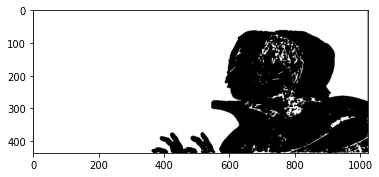

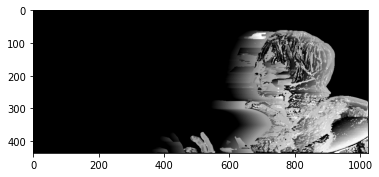

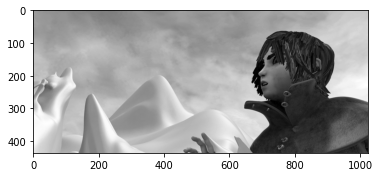

In [12]:

theme='ambush_2'
img='frame_0020.png'
base_dir='./resized'

plt.imshow(disp_map[:,:,0] ,cmap=plt.get_cmap('gray'))
plt.show()

plt.imshow(result ,cmap=plt.get_cmap('gray'))
plt.show()
left_img_thruth = cv2.imread(os.path.join(base_dir,'clean_left', theme, img),cv2.IMREAD_GRAYSCALE)
plt.imshow(left_img_thruth,cmap=plt.get_cmap('gray'))

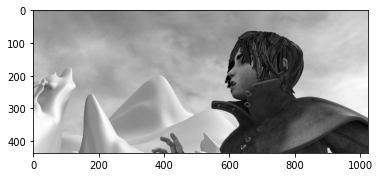

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

theme='ambush_2'
img='frame_0020.png'
base_dir='./resized'

left_img_thruth = cv2.imread(os.path.join(base_dir,'clean_right', theme, img),cv2.IMREAD_GRAYSCALE)
plt.imshow(left_img_thruth,cmap=plt.get_cmap('gray'))

max_disp 138


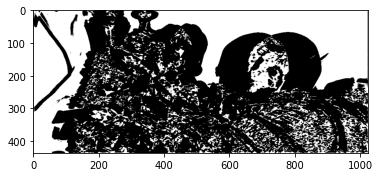

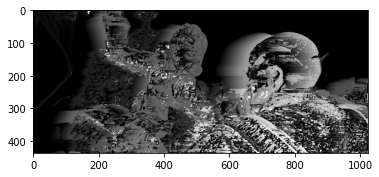

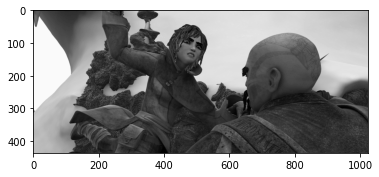

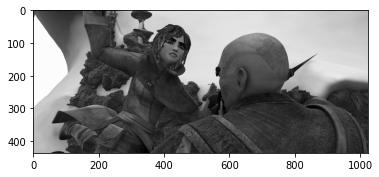

In [13]:
import matplotlib.pyplot as plt
disp_map = get_disp_map('ambush_6', 'frame_0010.png')


result = np.argmax(disp_map, axis=2)
result = result.astype('int16')

plt.imshow(disp_map[:,:,0] ,cmap=plt.get_cmap('gray'))
plt.show()

plt.imshow(result ,cmap=plt.get_cmap('gray'))
plt.show()
left_img_thruth = cv2.imread(os.path.join(base_dir,'clean_left', 'ambush_6', 'frame_0010.png' ),cv2.IMREAD_GRAYSCALE)
plt.imshow(left_img_thruth,cmap=plt.get_cmap('gray'))
plt.show()
left_img_thruth = cv2.imread(os.path.join(base_dir,'clean_right', 'ambush_6', 'frame_0010.png' ),cv2.IMREAD_GRAYSCALE)
plt.imshow(left_img_thruth,cmap=plt.get_cmap('gray'))
plt.show()

torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([1, 3, 11, 31])
torch.Size([2, 3, 11, 31])


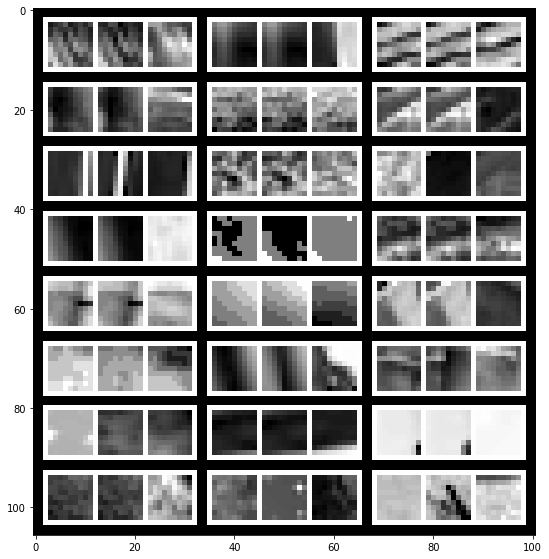

In [ ]:
import torchvision.utils as vutils


#batch_all = torch.zeros(27, 3, 11, 31, dtype=torch.float)
batch_all = []
for i in range(0, 72, 3):
  left_img = cv2.imread(os.path.join('./patches','train', f'{i}_left.png'),cv2.IMREAD_GRAYSCALE)
  right_pos_img = cv2.imread( os.path.join('./patches','train', f'{i}_right_pos.png'),cv2.IMREAD_GRAYSCALE)
  right_neg_img = cv2.imread(os.path.join('./patches','train', f'{i}_right_neg.png'),cv2.IMREAD_GRAYSCALE)

  batch = torch.zeros(3, 1, 9, 9, dtype=torch.float)
  batch[0,0,:,:] = torch.tensor(left_img, dtype=torch.float)
  batch[1,0,:,:] = torch.tensor(right_pos_img, dtype=torch.float)
  batch[2,0,:,:] = torch.tensor(right_neg_img, dtype=torch.float)

  img_comp = np.transpose(vutils.make_grid(batch, padding=1, normalize=True, pad_value=1, nrow=6), (1,2, 0))
  
  img_comp = img_comp.permute(2,0,1)
  batch_all.append(img_comp.unsqueeze(0))

print(torch.cat([batch_all[0], batch_all[1]], dim=0).size())
plt.figure(figsize=(9,20))
plt.imshow(np.transpose(vutils.make_grid(torch.cat(batch_all, dim=0), padding=2, normalize=True, pad_value=0, nrow=3), (1,2, 0)))


In [ ]:
!nvidia-smi

Wed Dec  9 14:24:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    33W / 250W |    903MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------